# Tema 10 - Evaluación de modelos de Machine Learning

Utilizando las medidas de rendimiento analizadas en el capítulo 10 del libro, tales como:

- Prediction Accuracy
- Error Rate
- Kappa Statistic
- Sensitivity
- Specifity
- Precision
- Recall
- F-Measure
- ROC Curves

Realice un análisis detallado de cualquiera de los modelos obtenidos en las
pruebas de evaluación de los temas 3, 4, 5 o 7. Comente los resultados obtenidos
  



Importamos dependencias

In [1]:
import pandas as pd # to load and manipulate data and for One-Hot Encoding
import numpy as np # to calculate the mean and standard deviation
import matplotlib.pyplot as plt 
import matplotlib.colors as colors

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import scale  
from sklearn.model_selection import GridSearchCV # this will do cross validation (grid search cross validation)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.svm import SVC  # SVM for classification


## Paso 1: importar datos

In [2]:
## import data
bank_raw = pd.read_csv(r"../Tema07/Bank/bank.csv",sep=';')

## Pasos 2, 3 y 4 (Exploración y preparación de los datos, entrenamiento, evaluación)

- Repetimos el procesado del dataset del mismo modo que en el Tema 7:

In [3]:
X = bank_raw.drop('y',axis=1).copy()
y = bank_raw['y'].copy()

#hot encoding for categorical variables
X_encoded = pd.get_dummies(X, columns=['job','marital','education','default','housing','loan','contact','poutcome'], dtype='int')

#encoding month (name to number)
from datetime import datetime
X_encoded['month'] = X_encoded['month'].apply(lambda m : datetime.strptime(m, '%b').month)

#create train test sets and scale them
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=99)

X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

In [4]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train.shape)
print(y_test.shape)

(3390, 40)
(1131, 40)
(3390,)
(1131,)


- Entrenamiento del modelo

Construimos el modelo sencillo, con los parámetros por defecto, al igual que en el Tema 7 (modelo 1).

In [5]:
%%time
#create classifier SVM
clf_svm = SVC(random_state=99) # kernel='rbf' by default
clf_svm_proba = SVC(probability=True, random_state=99)  # we need probabilities for the ROC curve

CPU times: user 31 μs, sys: 6 μs, total: 37 μs
Wall time: 39.3 μs


In [6]:
%%time
clf_svm.fit(X_train_scaled, y_train)

CPU times: user 148 ms, sys: 7.39 ms, total: 155 ms
Wall time: 154 ms


SVC(random_state=99)

In [7]:
%%time
#to predict probabilities
clf_svm_proba.fit(X_train_scaled, y_train)

CPU times: user 828 ms, sys: 15.8 ms, total: 844 ms
Wall time: 842 ms


SVC(probability=True, random_state=99)

- Predicción del modelo

In [8]:
predictions = clf_svm_proba.predict(X_test_scaled)
predictions_proba = clf_svm_proba.predict_proba(X_test_scaled)

cm = confusion_matrix(y_test, predictions, labels=clf_svm.classes_)
cm

array([[986,  13],
       [112,  20]])

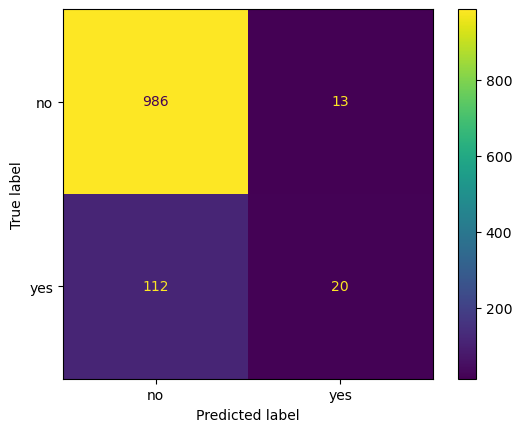

In [9]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf_svm.classes_)
disp.plot()
plt.show()

In [34]:
for i, prob in enumerate(predictions_proba):
    print(f"Sample {i+1}: Class 0 Probability = {prob[0]:.4f}, Class 1 Probability = {prob[1]:.4f}")
    if i==9:
        break

Sample 1: Class 0 Probability = 0.9321, Class 1 Probability = 0.0679
Sample 2: Class 0 Probability = 0.9167, Class 1 Probability = 0.0833
Sample 3: Class 0 Probability = 0.8333, Class 1 Probability = 0.1667
Sample 4: Class 0 Probability = 0.8888, Class 1 Probability = 0.1112
Sample 5: Class 0 Probability = 0.9712, Class 1 Probability = 0.0288
Sample 6: Class 0 Probability = 0.9291, Class 1 Probability = 0.0709
Sample 7: Class 0 Probability = 0.9455, Class 1 Probability = 0.0545
Sample 8: Class 0 Probability = 0.9080, Class 1 Probability = 0.0920
Sample 9: Class 0 Probability = 0.9682, Class 1 Probability = 0.0318
Sample 10: Class 0 Probability = 0.9745, Class 1 Probability = 0.0255


## Evaluación detallada de los resultados

El propósito en el tema 7 era analizar (predecir) si un cliente, en base a sus características, contratará un determinado producto bancario. Por esta razón, a la hora de obtener la matriz de confusión y todas las demás variables estadísticas, consideramos el "sí" como la clase positiva".

Otro factor a tener en cuenta, es que se trataba de un típico caso de dataset no balanceado:

In [11]:
#Summary of target variable
bankTable = bank_raw.groupby("y")
totals = bankTable.size()
total = sum(totals)
print(totals)
type(totals)

y
no     4000
yes     521
dtype: int64


pandas.core.series.Series

In [12]:
TP =  20
TN = 986
FP = 13  # type I error
FN =  112  # type II error
Total = TP + TN + FP + FN

- **Exactitud/accuracy**

Es la proporción de clasificados correctamente sobre el total (tanto si se considera una clase como la otra).

In [13]:
accuracy = (TP + TN) / (TP + FP + TN + FN)
print(round(accuracy,4))

0.8895


- **Error**

Es el "complementario" de la exactitud. Lógicamente se calcula:

In [14]:
error = 1 - accuracy
print(round(error,3))

0.111


- **Precisión**

La precisión es la proporción de predicciones de una clase que son realmente de esa clase:

In [15]:
precision = TP / (TP + FP)
print(round(precision,3))

0.606


Se puede ver que al tratarse de un dataset descompensado, y ser la clase positiva mucho menos numerosa, se obtiene una precisión bastante baja.

- **Recall** (Recuperación, o Tasa de verdaderos positivos (TPR))

La recuperación es la proporción de elementos de una clase que fueron clasificados correctamente como de esa clase.

In [16]:
recall = TP / (TP + FN)
print(round(recall,3))

0.152


- **F1 score** (Puntuación F1)

La puntuación F1 es la media armónica de la precisión y la recuperación.
Se calcula de la siguiente manera:

In [17]:
#F1 = 2 x (precision x recall) / (precision + recall) = 2TP / (2TP + FP + FN )

f1_score = 2 * (precision * recall) / (precision + recall)

print(round(f1_score,3))

0.242


Vemos que tiene un valor también muy bajo.

- **Sensibilidad**  ("Sensitivity", "True positive rate")

También llamada "fracción de verdaderos positivos", pone el foco en los casos positivos.
Su formulación matemática coincide con la del recall/recuperación.

In [18]:
sensitivity = TP / (TP + FN)
print(round(sensitivity,3))

0.152


- **Especificidad**  ("Especifity", "True negative rate")

La especifidad en cambio pone el foco en los casos negativos. Es la "fracción de verdaderos negativos".

(Para mí es el "negado" del recall).

In [19]:
specifity = TN / (TN + FP)
print(round(specifity,3))

0.987


Tenemos un dataset no balanceado, con muchos más casos negativos que positivos. 
El modelo aprende mejor por tanto a detectar estos casos negativos que los positivos.

- **Kappa**

Esta variable sirve para ajustar el valor de la exactitud, dado que se puede dar el caso de que parte de esa exactitud,
se deba simplemente al azar. 
Es considerada una medida más robusta y fiable que el simple valor de la exactitud.</br>

La Kappa de Cohen es una medida de la fiabilidad con la que dos 'evaluadores' miden lo mismo.  </br>

Su fórmula es la siguiente: </br>

k = (Pr(a) - Pr(e)) / (1 - Pr(e)) </br>

Donde:</br>
</br>
**Pr(a)** es el acuerdo observado relativo entre los observadores. </br>
**Pr(e)** es la probabilidad hipotética de acuerdo por azar, utilizando los datos observados para calcular las probabilidades
de que cada observador clasifique aleatoriamente cada categoría.

Si los evaluadores están completamente de acuerdo, entonces será κ = 1. </br>
Si no hay acuerdo ninguno entre los calificadores distinto al que cabría esperar por azar (según lo definido por Pr(e)), será κ = 0. 

In [20]:
#calculate Cohen's Kappa
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(y_test, predictions)

0.20532537393973127

- **Coeficiente de correlación de Matthews**

El coeficiente de correlación de Matthews coincide con el coeficiente phi φ o rφ en Estadística. </br>
Es una medida de la asociación entre dos variables binarias. </br>
En machine learning es considerado una medida de la calidad de una clasificación binaria. </br>
(También es similar su interpretación a la del coeficiente de correlación de Pearson). </br>

Su fórmula es: </br>

MCC = [TP × TN − FP × FN]  /  √[(TP + FP)(TP + FN)(TN + FP)(TN + FN)] </br>

In [21]:
import math
MCC = ((TP*TN)-(FP*FN)) / math.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN))
MCC

0.26422143613369703

Usando scikit-learn

In [22]:
#calculate MCC
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test, predictions)
mcc

0.26422143613369703

## Curvas ROC

La curva ROC (del inglés "Receiver Operating Characteristic") en machine learning, sirve para evaluar la calidad de un modelo
de clasificación binario mediante la representación de la proporción de verdaderos positivos (VPR = Razón de Verdaderos Positivos) frente a proporción de falsos positivos (FPR = Razón de Falsos Positivos), también según se varía el umbral de discriminación (valor a partir del cual se decide que un caso es un positivo). 

Para crear una curva ROC se necesitan 2 vectores de datos: uno con los valores reales, 
y otro con la probabilidad predicha por el modelo.

In [23]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
y_pred_proba = clf_svm_proba.predict_proba(X_test_scaled)[:, 1] 
y_test_int = y_test.map({'yes': 1, 'no': 0}).astype(int)  # we need ints, no yes/no

fpr, tpr, thresholds  = roc_curve(y_test_int, y_pred_proba)
roc_auc = auc(fpr, tpr)
roc_auc

0.8365486698820032

(En R obtuvimos algo más, claro: 0.8515)

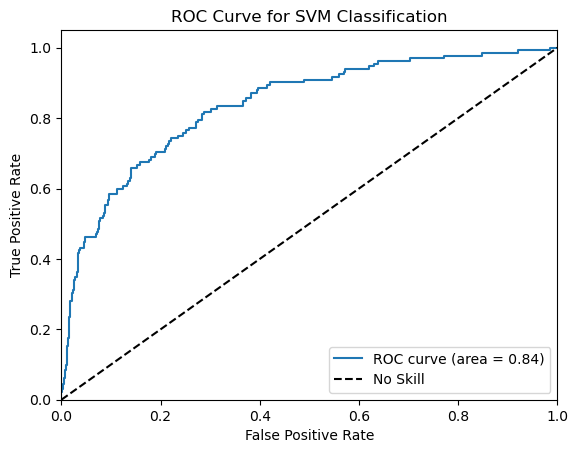

In [24]:
#plot ROC curve

# Plot the ROC curve
plt.figure()  

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM Classification')
plt.legend()

plt.show()

- **Comparar las curvas ROC de dos modelos**

In [25]:
# Model obtained in step 5 in Chapter 7 (below in "Anexo"):
clf_svm_CGamma_proba = SVC(C=1000, gamma=0.001, random_state=99, probability=True) 

clf_svm_CGamma_proba.fit(X_train_scaled, y_train)

y_pred_CGamma_proba = clf_svm_CGamma_proba.predict_proba(X_test_scaled)[:, 1] 

# Calculate ROC curve of this 2nd model:

fpr_CGamma, tpr_CGamma, thresholds_CGamma  = roc_curve(y_test_int, y_pred_CGamma_proba)
roc_auc_CGamma = auc(fpr_CGamma, tpr_CGamma)
roc_auc_CGamma

0.8177419844086511

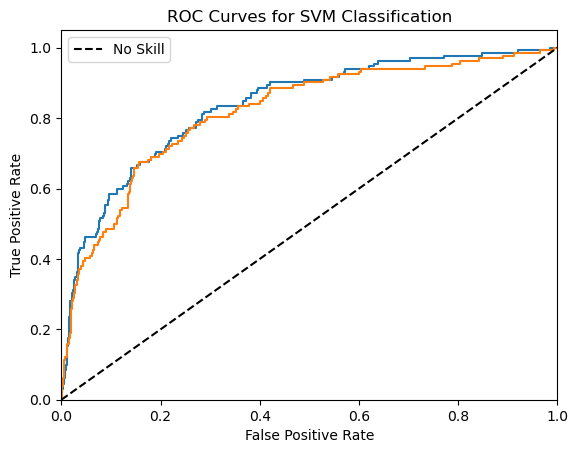

In [26]:
# Plot the ROC curve
plt.figure()  

plt.plot(fpr, tpr, fpr_CGamma, tpr_CGamma)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for SVM Classification')
plt.legend()

plt.show()

De igual manera que los valores Kappa, F1, MCC indican que la calidad de la predición no es muy buena, lo mismo indican estas gráficas: se ve que las líneas de ambos modelos están bastante alejadas de la esquina superior izquierda. 
(Y la diferencia entre ellos es prácticamente inexistente. La diferencia de las AUCs es muy pequeña).

---

## ANEXO


Para obtener los mejores valores de C y gamma usamos la función GridSearchCV:

In [27]:
%%time
# We try to find the best C and gamma conbination
param_grid=[
    {'C': [1,10,100,1000],
     'gamma': [0.1, 0.01, 0.001, 0.0001],
     'kernel': ['rbf']},
]
optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=20,
    verbose=1
)
optimal_params.fit(X_train_scaled, y_train)
optimal_params.best_params_

Fitting 20 folds for each of 16 candidates, totalling 320 fits
CPU times: user 1min 4s, sys: 291 ms, total: 1min 4s
Wall time: 1min 4s


{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Entonces el mejor clasificador es:

In [28]:
clf_svm_CGamma = SVC(C=1000, gamma=0.001, random_state=99) 

In [29]:
%%time

clf_svm_CGamma.fit(X_train_scaled, y_train)

CPU times: user 420 ms, sys: 0 ns, total: 420 ms
Wall time: 420 ms


SVC(C=1000, gamma=0.001, random_state=99)

In [30]:
def classifier_testing(clf, X_train, X_test, y_train, y_test):
    # Training
    clf.fit(X_train, y_train)
  
    #Predictions
    y_pred = clf.predict(X_test)

    #Accuracy
    clf_accuracy_score = round(accuracy_score(y_test, y_pred)*100, 2)
    print("Accuracy Score:\n", clf_accuracy_score, "\n")

    #Confusion Matrix
    conf_mtx = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", conf_mtx, "\n")
    
    #Classification Report
    class_rep = classification_report(y_test, y_pred)
    print("Classification Report:\n", class_rep, "\n")

In [31]:
classifier_testing(clf_svm, X_train_scaled, X_test_scaled, y_train, y_test)

Accuracy Score:
 88.95 

Confusion Matrix:
 [[986  13]
 [112  20]] 

Classification Report:
               precision    recall  f1-score   support

          no       0.90      0.99      0.94       999
         yes       0.61      0.15      0.24       132

    accuracy                           0.89      1131
   macro avg       0.75      0.57      0.59      1131
weighted avg       0.86      0.89      0.86      1131
 



In [32]:
classifier_testing(clf_svm_CGamma, X_train_scaled, X_test_scaled, y_train, y_test)

Accuracy Score:
 89.57 

Confusion Matrix:
 [[973  26]
 [ 92  40]] 

Classification Report:
               precision    recall  f1-score   support

          no       0.91      0.97      0.94       999
         yes       0.61      0.30      0.40       132

    accuracy                           0.90      1131
   macro avg       0.76      0.64      0.67      1131
weighted avg       0.88      0.90      0.88      1131
 



El resultado es 89.57%, prácticamente lo mismo que lo obtenido en R (89.65%).

In [33]:
#Session info

import session_info
session_info.show(html=False)

-----
matplotlib          3.10.0
numpy               1.26.4
pandas              2.2.3
session_info        1.0.0
sklearn             1.6.1
-----
IPython             8.30.0
jupyter_client      8.6.3
jupyter_core        5.7.2
jupyterlab          4.3.6
-----
Python 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:53:32) [GCC 12.3.0]
Linux-6.1.0-32-amd64-x86_64-with-glibc2.36
-----
Session information updated at 2025-04-10 21:05
